In [1]:
import networkx as nx 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import optimize
import scipy
import sys


from src import SingleAgent as sa
from src import SimGame as sg
from src import helperfunctions as hf

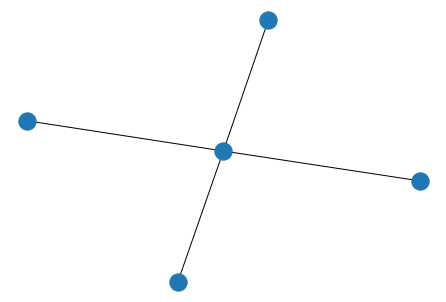

In [2]:

G = nx.star_graph(4)



h = np.zeros(len(G.nodes.keys()))


nx.draw(G)

In [ ]:


import networkx as nx 
import numpy as np
import math    
import torch
import torch.optim as optim
from itertools import permutations
from functools import reduce
from torch.autograd import grad



from src import helperfunctions as hf


class mf_ising_system:

    def __init__(self,graph,background_field,fixed_point_iter=int(5*1e4),init_mag='aligned',fp_tol_fac=1e-6,
        iim_iter=1000,step_size=1.0,iim_tol_fac=1e-5,optimiser_type='sgd',momentum=0.4):
        
        self.graph = graph
        self.adj_matrix = nx.to_numpy_matrix(graph)
        self.graph_size = len(graph.nodes.keys())
        self.background_field = background_field
        self.fixed_point_iter=fixed_point_iter
        self.iim_iter = iim_iter
        self.fp_tol_fac=fp_tol_fac
        self.iim_tol_fac=iim_tol_fac
        self.optimiser_type = optimiser_type
        self.momentum = momentum
        self.step_size=step_size
        if init_mag=='aligned':
            self.init_mag=np.ones(self.graph_size)
        elif init_mag=='random':
            self.init_mag=np.array([np.random.choice([-1,1]) for i in range(self.graph_size)])
        else:
            self.init_mag = init_mag 
            
        
    def single_mag(self,i,m,beta,field):
        gamma=1.0
        spin_field = np.dot(self.adj_matrix[i],m) 
        term = math.tanh(beta*(spin_field+field[i]))
        return (1.0-gamma)*m[i] + gamma*term
    
    def magnetisation(self,mag,beta,field):
        m_old = mag
        m_new = np.zeros(len(m_old))
        for i in range(self.graph_size):
            m_new[i]=self.single_mag(i,m_old,beta,field)
        return m_new

    def aitken_method(self,mag0,beta,field):      
        # Numerical Analysis Richard L.Burden 9th Edition, p. 105
        
        mag1=self.magnetisation(mag0,beta,field)
        for i in range(self.fixed_point_iter):     
            mag2=self.magnetisation(mag1,beta,field)   
            if np.all((mag0+mag2-2*mag1)!=0):
                mag_d = mag0 - (mag1-mag0)**2/(mag0+mag2-2*mag1) 
            else:
                mag_d = mag1
            
            if abs(np.sum(mag0)-np.sum(mag_d))<self.fp_tol_fac: 
                break
            mag0=mag1
            mag1=mag2
            if i+1==self.fixed_point_iter:
                print('Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter')
                mag_d = mag1
 
        self.mag_delta_history.append(mag_d)
        return mag_d
    
    def mag_grad(self,beta,mag):
        # Mean Field Susceptibility;
        
        if all([math.isclose(i,j,abs_tol=1e-5) for i,j in zip(mag,np.ones(len(mag)))]):
            gradient = np.zeros(len(mag))
        else:
            D=np.identity(self.graph_size)*np.array([(1-i**2) for i in mag]) # equals to 0 if all m's are 1 or close to 1
            inv = np.linalg.inv(np.identity(self.graph_size)-beta*D*self.adj_matrix)
            susc_matrix = beta*inv*D
            gradient = np.sum(susc_matrix,axis=1).A1
            self.gradient_history.append(gradient)
        return gradient
    
    def sgdm(self,grad,control_field,changes,it):
        new_change = self.step_size * grad + self.momentum * changes[it]
        control_field_update = control_field + new_change
        changes.append(new_change)
        return control_field_update,changes
    

    def MF_IIM(self,field_budget,beta,init_control_field='uniform'):
              
        if init_control_field=='uniform':
            control_field = (field_budget/self.graph_size)*np.ones(self.graph_size)
        else:
            control_field = init_control_field

        # initial magnetisation as influenced by initial budget spread
        # note: different from init_mag which denotes initial magnetisation *without* the external field      
        tot_field = np.array(self.background_field+control_field)

        self.control_field_history=[]
        self.control_field_history.append(control_field)
        self.mag_delta_history =[]
        self.gradient_history=[]
        mag_i= self.aitken_method(self.init_mag,beta,tot_field)
        

        changes = [np.zeros(self.graph_size)]
        for it in range(self.iim_iter):
            if field_budget!=0:
                mag_i_grad = self.mag_grad(beta,mag_i)
                control_field = self.control_field_history[it]

                if self.optimiser_type=='sgd':
                    control_field_update = (control_field + self.step_size*mag_i_grad)
                elif self.optimiser_type =='sgdm':
                    control_field_update,changes = self.sgdm(mag_i_grad,control_field,changes,it)

                mag_temp=self.aitken_method(mag_i,beta,control_field_update)
                self.gradient_history.append(self.mag_grad(beta,mag_temp))
                control_field_new = hf.projection_simplex_sort(control_field_update.T,z=field_budget)
                #control_field_new = control_field_update

            elif field_budget==0:
                control_field_new = np.zeros(self.graph_size)
    
            tot_field = np.array(self.background_field+control_field_new)
            mag_ii= self.aitken_method(mag_i,beta,tot_field)

            if np.abs(np.mean(mag_ii)-np.mean(mag_i)) <= self.iim_tol_fac:
                final_mag=mag_ii
                break
            self.control_field_history.append(control_field_new)
            mag_i=mag_ii
        if it==self.iim_iter-1:
            print('Failed to converge after {} iterations'.format(self.iim_iter))
            final_mag = mag_ii
            
        return control_field,final_mag
            


In [ ]:
import networkx as nx 
import numpy as np
import math
from tqdm import tqdm
import numba
from numba.experimental import jitclass
from numba import jit




steadyspec = [
    ('adj_matrix',numba.float64[:,:]),
    ('graph_size',numba.int32),
    ('background_field',numba.float64[:]),
    ('fixed_point_iter',numba.int32),
    ('fp_tol_fac',numba.float64),
]


@jitclass(steadyspec)
class steady_state(object):
    def __init__(self,adj_matrix,fixed_point_iter=10000,fp_tol_fac=1e-6):

        self.adj_matrix = adj_matrix
        self.graph_size = self.adj_matrix.shape[0]
        self.fixed_point_iter=fixed_point_iter
        self.fp_tol_fac=fp_tol_fac


    def single_mag(self,i,m,beta,field):
        gamma=1.0
        spin_field = self.adj_matrix[i].dot(m)
        term = math.tanh(beta*(spin_field+field[i]))
        return (1.0-gamma)*m[i] + gamma*term

    def magnetisation(self,mag,beta,field):
        m_old = mag
        m_new = np.zeros(len(m_old))
        for i in range(self.graph_size):
            m_new[i]=self.single_mag(i,m_old,beta,field)
        return m_new

    def aitken_method(self,mag0,beta,field):      
        mag1=self.magnetisation(mag0,beta,field)
        for i in range(self.fixed_point_iter):     
            mag2=self.magnetisation(mag1,beta,field)   
            if ((mag0+mag2-2*mag1)!=0).all():
                mag_d = mag0 - (mag1-mag0)**2/(mag0+mag2-2*mag1) 
            else:
                mag_d = mag1

            if abs(np.sum(mag0)-np.sum(mag_d))<self.fp_tol_fac: 
                break
            mag0=mag1
            mag1=mag2
            if i+1==self.fixed_point_iter:
                mag_d = mag1

        return mag_d

@jit(nopython=True) 
def isclose(a,b):
    return abs(a-b) <= max(1e-9 * max(abs(a), abs(b)), 1e-5)


@jit(nopython=True) 
def susc_grad(beta,mag,adj_matrix):
    D=np.identity(mag.shape[0])*np.array([(1-i**2) for i in mag]) 
    inv = np.linalg.inv(np.identity(mag.shape[0])-beta*D.dot(adj_matrix))
    susc_matrix = beta*inv.dot(D)
    gradient = np.sum(susc_matrix,axis=1).flatten()

    return gradient

def mag_grad(beta,mag,adj_matrix):
    if np.all([isclose(i,j) for i,j in zip(mag,np.ones(mag.shape[0]))]):
        return np.zeros(len(mag))
    else:
        return susc_grad(beta,mag,adj_matrix)



@jit(nopython=True)
def projection_simplex_sort(v, z):
    n_features = v.shape[0]
    v = np.abs(v)
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w


@jit(nopython=True) 
def lr_1(x,iim_iter=5000):
    return np.exp(-x/(0.1*iim_iter))

@jit(nopython=True) 
def lr_2(x,iim_iter=5000):
    return np.exp(-x/(0.1*iim_iter))

@jit(nopython=True) 
def adam(grad,it,typ,ms,vs,iim_iter,beta1=0.9,beta2=0.999,eps=0.1):
    if typ=='pos':
        lr=lr_1(it)
    elif typ=='neg':
        lr=lr_2(it)
    ms_new = beta1 * ms + (1.0 - beta1) * grad
    vs_new = beta2 * vs + (1.0 - beta2) * grad**2
    mhat = ms_new / (1.0 - beta1**(it+1))
    vhat = vs_new / (1.0 - beta2**(it+1))
    ms = ms_new
    vs = vs_new
    change = lr* mhat/(np.sqrt(vhat) + eps)
    return change,ms,vs

class mf_ising_system():
    def __init__(self,graph,background_field,iim_iter=10000,iim_tol_fac=1e-3):

        self.graph=graph
        self.adj_matrix = nx.to_numpy_matrix(graph).astype(np.float64)
        self.graph_size = self.adj_matrix.shape[0]
        self.background_field = background_field.astype(np.float64)
        self.iim_iter=iim_iter
        self.iim_tol_fac = iim_tol_fac
        

    def positive_agent(self,mag_i,it,pos_budget,beta):
        mag_i_grad = mag_grad(beta,mag_i,self.adj_matrix)
        control_field = self.control_field_history_pos[-1]
        change,ms,vs = adam(mag_i_grad,it,'pos',self.ms_pos,self.vs_pos,self.iim_iter)
        self.ms_pos=ms
        self.vs_pos=vs
        control_field_update = control_field  + change
        control_field_new = projection_simplex_sort(control_field_update.T,pos_budget)
        #control_field_new=control_field_update
        self.control_field_history_pos.append(control_field_new)
        return control_field_new,mag_i_grad
    
    def negative_agent(self,mag_i,it,neg_budget,beta):
        mag_i = -1.0*mag_i
        mag_i_grad = -mag_grad(beta,mag_i,self.adj_matrix)
        control_field = self.control_field_history_neg[-1]
        change,ms,vs=adam(mag_i_grad,it,'neg',self.ms_neg,self.vs_neg,self.iim_iter)
        self.ms_neg=ms
        self.vs_neg=vs
        control_field_update = control_field + change
        control_field_new = projection_simplex_sort(control_field_update.T,neg_budget)
        #control_field_new=control_field_update
        self.control_field_history_neg.append(control_field_new)
        
        return control_field_new,mag_i_grad
        
    def second_partial_dffs(self,state,mag_ii,tot_field,beta,a=1e-5):
        update = a*np.ones(self.graph_size)
        upper_change=tot_field+update
        mag_plus= -state.aitken_method(mag_ii,beta,upper_change)
        grad_plus = -mag_grad(beta,mag_plus,self.adj_matrix)

        lower_change = tot_field-update
        mag_minus= -state.aitken_method(mag_ii,beta,lower_change)
        grad_minus = -mag_grad(beta,mag_minus,self.adj_matrix)
        second_total_grad =  (grad_plus - grad_minus)/(2*update) # central difference formula
        curv_player_neg = - second_total_grad # minus because product rule : H_pos = H_pos - H_neg
        curv_player_pos = curv_player_neg
        return np.array([curv_player_pos,curv_player_neg])
    
    def init_lists(self):
        self.control_field_history_pos =[]
        self.control_field_history_neg = []
        self.mag_history = []
        self.pos_gradient_history=np.zeros((self.iim_iter,self.graph_size))
        self.neg_gradient_history=np.zeros((self.iim_iter,self.graph_size))
        
        self.ms_pos = np.zeros(self.graph_size,dtype=np.float64)
        self.vs_pos = np.zeros(self.graph_size,dtype=np.float64)
        self.ms_neg = np.zeros(self.graph_size,dtype=np.float64)
        self.vs_neg = np.zeros(self.graph_size,dtype=np.float64)
        

    def MF_IIM(self,pos_budget,neg_budget,beta,init_alloc='random',progress=True):
 
        if isinstance(init_alloc,(np.ndarray, np.generic)):
            control_field_pos = init_alloc[0,:]
            control_field_neg = init_alloc[1,:] 
        elif isinstance(init_alloc,str):  
            if  init_alloc=='aligned':
                control_field_pos =( pos_budget /self.graph_size)*np.ones(self.graph_size)
                control_field_neg = ( neg_budget /self.graph_size)*np.ones(self.graph_size)
            elif init_alloc=='random':
                control_field_pos  = np.random.dirichlet(np.ones(self.graph_size))*pos_budget
                control_field_neg  = np.random.dirichlet(np.ones(self.graph_size))*neg_budget
  
        init_mag = np.array([np.random.choice([-1,1]) for i in range(self.graph_size)]).astype(np.float64)

        self.init_lists()

        self.control_field_history_pos.append(control_field_pos)
        self.control_field_history_neg.append(control_field_neg)
        
        self.gradient_history=[]
        state = steady_state(self.adj_matrix)
        self.state=state

        tot_field = control_field_pos-control_field_neg
        
        mag_i = state.aitken_method(init_mag,beta,tot_field)
        self.mag_history.append(mag_i)

        for it in tqdm(range(self.iim_iter)) if progress else range(self.iim_iter):
            
            gradients=[]
            if pos_budget!=0:
                control_pos,pos_gradient = self.positive_agent(mag_i,it,pos_budget,beta)
                tot_field +=control_pos
                self.pos_gradient_history[it]=pos_gradient
                gradients.append(pos_gradient)
                self.gradient_history.append(pos_gradient)

            if neg_budget!=0:
                control_neg,neg_gradient = self.negative_agent(mag_i,it,neg_budget,beta)
                tot_field-=control_neg
                self.neg_gradient_history[it]=neg_gradient
                gradients.append(neg_gradient)

            mag_ii= state.aitken_method(mag_i,beta,tot_field)
            
            self.mag_history.append(mag_ii)
            
#             if (all(np.abs(self.control_field_history_pos[-1]-self.control_field_history_pos[-2])<self.iim_tol_fac) and 
#                 all(np.abs(self.control_field_history_neg[-1]-self.control_field_history_neg[-2])<self.iim_tol_fac)):
#                 break
            if np.all([(abs(gradient)<self.iim_tol_fac).all() for gradient in gradients]):
                second_dffs=self.second_partial_dffs(state,mag_ii,tot_field,beta)
                if (second_dffs[0]<0).all() and (second_dffs[1]<0).all():
                    break
            
            mag_i=mag_ii
            tot_field=0.0
        if it==self.iim_iter-1:
            print('Failed to converge after {} iterations'.format(self.iim_iter))
            final_mag = mag_ii
            
        elif it < self.iim_iter-1:
            final_mag = mag_ii
        
        self.control_field_history_pos = np.array(self.control_field_history_pos)
        self.control_field_history_neg = np.array(self.control_field_history_neg)
        self.mag_history = np.array(self.mag_history)

        return self.control_field_history_pos[-1],self.control_field_history_neg[-1],final_mag

In [ ]:
        
                
budget_pos=1.0
budget_neg=1.0
h = np.zeros(len(G.nodes.keys()))
beta=0.2

system = mf_ising_system(G,h,iim_iter=10000,step_size=0.01)

beta_crit=hf.crit_b(system.adj_matrix)

control,mag=system.MF_IIM(budget_pos,beta)
print(control)


hf.projection_simplex_sort(control.T,z=budget_pos)

In [ ]:
import matplotlib

matplotlib.rcParams.update({'font.size': 14,'figure.figsize':(5,5),'axes.labelsize': 'large',
                           'axes.titlesize':18})



x=np.array(system.gradient_history)


plt.plot(x[:,0],label='hub')
plt.plot(x[:,1])
plt.plot(x[:,2])
plt.plot(x[:,3])
plt.plot(x[:,4],label='peripheral')
plt.title('competitive setting \n constrained gradient')
plt.legend()


In [ ]:
def average_degree(system,control,budget):
    return np.sum([system.graph.degree[i]*con for i,con in enumerate(control)])/budget


# gradient history
plt.plot(system.grad_history)
plt.title('Gradient proposed in the paper - susceptibility ')
plt.show()

# mag history

Y = []
for mag in system.mag_delta_history:
    Y.append(sum(mag))
plt.title('Magnetisation over time')
plt.plot(Y)
plt.show()
    
# gradient computed by numpy 
plt.title('gradient computed analytically \n from values of magnetisation')
plt.plot(np.gradient(Y))
plt.show()

    
    
    


In [ ]:
exp_beta_list = np.logspace(-0.7, 0.5, endpoint=True,num=100)
iters=10
runs =np.zeros((iters,len(exp_beta_list),system.graph_size))
mags = np.zeros((iters,len(exp_beta_list),system.graph_size))
for run in range(runs.shape[0]):
    control_history=[]
    for i,beta in enumerate(exp_beta_list):
        system = sa.mf_ising_system(G,h,iim_iter=1000,fp_tol_fac=10-4)
        control,mag=system.MF_IIM(budget,beta)
        control_history.append(control)
        if i%100==0:
            print(i,beta)
        runs[run,i,:]=control
        mags[run,i,]=mag

        
mean_run = np.mean(runs,axis=0)
var_run = np.var(runs,axis=0)
mean_mag = np.mean(mags,axis=0)
print('FINISHED')    

In [ ]:


import matplotlib


avs_deg=np.zeros(len(mean_run))
var_deg = np.zeros(len(mean_run))
for it,control in enumerate(mean_run):
    average_degree = np.sum([G.degree[i]*con for i,con in enumerate(control)])
    variance_degree = np.sum([G.degree[i]**2*var for i,var in enumerate(var_run[it])])
    avs_deg[it]=average_degree
    var_deg[it]=variance_degree

fig,ax = plt.subplots(figsize=(9,5))

ax.scatter(exp_beta_list,avs_deg,s=8)
ax.set_xscale(value='log')
ax.fill_between(exp_beta_list, avs_deg-np.sqrt(var_deg), avs_deg+np.sqrt(var_deg),
                    **{'color':'green','alpha':0.5})


ax.set_xticks([0.2,0.3,0.5,1.0,2.0, 3.0])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_ylabel('Average degree')
ax.set_xlabel(r'Interaction Strenght (beta)')
plt.show()


In [35]:
from itertools import permutations
from functools import reduce
import numdifftools as nd
import numba
from numba import jit



class TrueSolution:

    def __init__(self,graph,beta,init_mag='random',mu=2.0):
        self.adj_matrix = nx.to_numpy_matrix(graph)
        self.graph_size = len(graph.nodes.keys())
        possible_configs = np.zeros([2**self.graph_size,self.graph_size],dtype=np.float64)
        all_pos,all_neg = np.ones(self.graph_size),(-1)*np.ones(self.graph_size)
        for i,p in enumerate(self.unique_permutations(np.concatenate((all_pos,all_neg)),self.graph_size)):
            possible_configs[i]=p
        self.possible_configs = possible_configs # possible spin configurations
        self.beta=beta


    def unique_permutations(self,iterable, r=None):
        previous = tuple()
        for p in permutations(sorted(iterable), r):
            if p > previous:
                previous = p
                yield p    

    def hamiltonian(self,m,h):
        x=np.sum([float(m[i]*self.adj_matrix[i,:]@m) for i in range(self.graph_size)])/2.0 + h@m
        return -x  


    def partition_function(self,h,beta):
        term = np.array([np.exp(-beta*self.hamiltonian(self.possible_configs[i],h)) for i in range(self.possible_configs.shape[0])])
        
        return np.sum(term)

    def boltzmann(self,h,beta,j):
        " j - configuration index"
        mag_ins = self.possible_configs[j]
        term = 1/self.partition_function(h,beta) * np.exp(-beta*self.hamiltonian(mag_ins,h))
        return term

    def magnetisation(self,h):
        beta = self.beta
        m = np.zeros(self.graph_size)
        for ix in range(m.shape[0]):
            m_i = np.array([self.possible_configs[j,ix]*self.boltzmann(h,beta,j) for j in range(self.possible_configs.shape[0])])
            m[ix]=np.sum(m_i)
        return m

    def projection_simplex_sort(self,v, z=1.0):
        n_features = v.shape[0]
        v = np.abs(v)
        u = np.sort(v)[::-1]
        cssv = np.cumsum(u) - z
        ind = np.arange(n_features) + 1
        cond = u - cssv / ind > 0
        rho = ind[cond][-1]
        theta = cssv[cond][-1] / float(rho)
        w = np.maximum(v - theta, 0)
        return w
    
    def max_mag(self,beta,budget,iters=100,lr=0.5): 
        per_spin = budget/self.graph_size
        h = per_spin*np.ones(self.graph_size)
        h_history=np.zeros((iters,self.graph_size))
        for i in range(iters):
            grad=nd.Gradient(self.magnetisation)([h])
            h+=lr*np.sum(grad,axis=1)
            h = self.projection_simplex_sort(h,budget)
            if sum(abs(h-h_history[-1,:]))<1e-4:
                break
            h_history[i]=h
        return h
    


In [37]:


budget=1.0

beta_list = np.logspace(-0.7, 0.5, endpoint=True,num=10)

iters=1
th_runs =np.zeros((iters,len(beta_list),system.graph_size))

for run in range(th_runs.shape[0]):
    system = TrueSolution(G,beta)
    for i,beta in enumerate(beta_list):
        H= system.max_mag(beta,budget)
        if i%1==0:
            print(i)
        th_runs[run,i,:]=H
        

        
mean_th_run = np.mean(th_runs,axis=0)
var_th_run = np.var(th_runs,axis=0)
print('FINISHED')

0


KeyboardInterrupt: 

[]

In [ ]:
realsystem = TrueSolution(G)




def bruteforce(system,beta,N=100,budget=1.0):
    xarray=np.linspace(0,budget,N)
    yarray = lambda x:budget-x # x being an elements from xarray
    magnetisation=np.zeros((len(xarray),2))
    for i,x in enumerate(xarray):
        t = np.array([x,yarray(x)/4.0,yarray(x)/4.0,yarray(x)/4.0,yarray(x)/4.0])
        H =  torch.from_numpy(t)
        m= realsystem.magnetisation(H,beta)
        magnetisation[i]=np.array([x,np.sum(m.detach().numpy())])

    h1 = magnetisation[np.argmax(magnetisation[:,1]),0]
    hn = 1.0-h1
    H = np.array([h1,hn/4.0,hn/4.0,hn/4.0,hn/4.0])
    return H
   
    
    
magnetisation=bruteforce(realsystem,0.25)

print(magnetisation)

magnetisation=bruteforce(realsystem,2.0)

print(magnetisation)

In [ ]:
#beta=0.9
# GRADIENT DESCENT WITH ADAM


def adam(H,i,m,v,lr,beta1=0.9,beta2=0.999,eps=1e-8):
    m = beta1 * m + (1.0 - beta1) * H.grad.data
    v= beta2 * v + (1.0 - beta2) * H.grad.data**2
    mhat = m / (1.0 - beta1**(i+1))
    vhat = v/ (1.0 - beta2**(i+1))
    H.data.add_(lr * mhat / (torch.sqrt(vhat) + eps))
    return H 



def sgdm(H,i,changes,momentum,lr):
    new_change = lr * H.grad.data + momentum * changes[i]
    H.data.add_(new_change)
    changes[i+1]=new_change
    return H,changes


def theoretical_mag(system,beta,lr,momentum):
    epochs =500
    per_spin = (budget)/system.graph_size
    H = per_spin*torch.ones(system.graph_size,dtype=torch.float64)
    H.requires_grad=True
  
    h_history=np.zeros((epochs,system.graph_size))
    g_history = np.zeros((epochs,system.graph_size))
    

    m = torch.zeros(system.graph_size)
    v = torch.zeros(system.graph_size)

    changes = torch.zeros((epochs+1,system.graph_size))
    
    for i in range(epochs):
        output = system.magnetisation(H,beta) # note the sign, so that it correspond to maximisation
        output.backward(torch.ones_like(H))
        
        #H = adam(H,i,m,v,lr)
        H,changes=sgdm(H,i,changes,momentum,lr)
        #H.data.add_(lr * H.grad.data)
        H.data = hf.projection_simplex_sort_torch(H, z=budget)
        H.grad.detach_()
        h_grad = H.grad.data.detach().numpy()
        g_history[i]=h_grad
        H.grad.zero_()
        #print(i,h_grad)
        h_arr = H.detach().numpy()
        h_history[i]=h_arr
        assert np.round(np.sum(h_arr),3)==budget
        
        #last_gradient=np.gradient(h_history,axis=1)[-1]
        
        if all(np.abs(h_arr-h_history[i-1])<1e-5):
            break
        if i==epochs-1:
            print('Did not converge.')
        
        
    return H.detach().numpy(),h_history
    
    
lr = 0.1
momentum=1.0

tx,history= theoretical_mag(realsystem,2.0,lr,momentum)
print(tx)




In [ ]:
np.gradient(history,axis=1)[-1]

In [ ]:
plt.plot(history)

In [ ]:


plt.plot(xarray,magnetisation[:,1],label='hub val')
plt.plot((1.0-xarray)/4.0,magnetisation[:,1],label='peripheral val')
plt.ylabel('magnetisation')
plt.legend()
plt.xlabel('value of control field components')
plt.axhline(y=max(magnetisation[:,1]), color='r', linestyle='dashed')



In [ ]:
beta_list = np.logspace(-0.7, 0.5, endpoint=True,num=10)

iters=1
th_runs =np.zeros((iters,len(beta_list),system.graph_size))

for run in range(th_runs.shape[0]):
    realsystem = TrueSolution(G)
    for i,beta in enumerate(beta_list):
        H= bruteforce(realsystem,beta)
        if i%10==0:
            print(i)
        th_runs[run,i,:]=H
        

        
mean_th_run = np.mean(th_runs,axis=0)
var_th_run = np.var(th_runs,axis=0)
print('FINISHED')   

In [ ]:
mean_th_run = np.mean(th_runs,axis=0)
var_th_run = np.var(th_runs,axis=0)
mean_th_run


In [ ]:

plt.plot(xarray,magnetisation[:,1],label='hub val')
plt.plot((1.0-xarray)/4.0,magnetisation[:,1],label='peripheral val')
plt.ylabel('magnetisation')
plt.legend()
plt.xlabel('value of control field components')
plt.axhline(y=max(magnetisation[:,1]), color='r', linestyle='dashed')




In [ ]:

lr = 0.1
momentum=1.0
beta_list = np.logspace(-0.7, 0.5, endpoint=True,num=100)


iters=1
th_runs =np.zeros((iters,len(beta_list),system.graph_size))

for run in range(th_runs.shape[0]):
    realsystem = TrueSolution(G)
    for i,beta in enumerate(beta_list):
        tx,history = theoretical_mag(realsystem,beta,lr,momentum)
        if i%10==0:
            print(i,tx,'learning rate',lr,'iteration',i)
            #lr = max(lr*0.5,0.01)
        th_runs[run,i,:]=tx
        

        
mean_th_run = np.mean(th_runs,axis=0)
var_th_run = np.var(th_runs,axis=0)
print('FINISHED')    

In [ ]:
th_runs

In [ ]:
import matplotlib


avs_deg_theory=np.zeros(len(mean_th_run))
var_deg_theory = np.zeros(len(mean_th_run))
for it,control in enumerate(mean_th_run):
    average_degree = np.sum([G.degree[i]*con for i,con in enumerate(control)])
    variance_degree = np.sum([G.degree[i]**2*var for i,var in enumerate(var_th_run[it])])
    avs_deg_theory[it]=average_degree
    var_deg_theory[it]=variance_degree

    
matplotlib.rcParams.update({'font.size': 14,'figure.figsize':(10,5),'axes.labelsize': 'large',
                           'axes.titlesize':18})


    
fig,ax = plt.subplots()

ax.scatter(beta_list,avs_deg_theory,label='True Optimal',c='blue')
ax.fill_between(beta_list, avs_deg_theory-np.sqrt(var_deg_theory), avs_deg_theory+np.sqrt(var_deg_theory),
                    **{'color':'blue','alpha':0.5})




ax.scatter(exp_beta_list,avs_deg,label='MF-IIM solution',c='orange')
ax.fill_between(exp_beta_list, avs_deg-np.sqrt(var_deg), avs_deg+np.sqrt(var_deg),
                    **{'color':'orange','alpha':0.5})


ax.vlines(beta_crit,ymin=1,ymax=4,linestyles='dashed',color='black',label=r'$\beta_{crit}$')

ax.legend()
ax.set_xscale(value='log')
ax.set_title('MF-IIM solution vs. the True Optimal solution')

ax.set_xticks([0.2,0.3,0.5,1.0,2.0, 3.0])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_ylabel('Average degree')
ax.set_xlabel(r'Interaction Strenght ($\beta$)')
plt.show()

In [ ]:
fig,ax = plt.subplots(figsize=(15,5),ncols=2)


ax[0].scatter(beta_list,avs_deg_theory,label='True Optimal',c='blue')
ax[0].fill_between(beta_list, avs_deg_theory-np.sqrt(var_deg_theory), avs_deg_theory+np.sqrt(var_deg_theory),
                    **{'color':'blue','alpha':0.5})




ax[0].scatter(exp_beta_list,avs_deg,label='MF-IIM solution',c='orange')
ax[0].fill_between(exp_beta_list, avs_deg-np.sqrt(var_deg), avs_deg+np.sqrt(var_deg),
                    **{'color':'orange','alpha':0.5})


ax[0].vlines(beta_crit,ymin=1,ymax=4,linestyles='dashed',color='black',label=r'$\beta_{crit}$')

ax[0].legend()
ax[0].set_xscale(value='log')

ax[0].set_xticks([0.2,0.3,0.5,1.0,2.0, 3.0])
ax[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[0].set_ylabel('Average degree')
ax[0].set_xlabel(r'Interaction Strenght ($\beta$)')



ax[1].plot(beta_list,avs_deg/avs_deg_theory,label='True Optimal',c='blue')

ax[1].vlines(beta_crit,ymin=min(avs_deg/avs_deg_theory),ymax=max(avs_deg/avs_deg_theory),linestyles='dashed',color='black',label=r'$\beta_{crit}$')

ax[1].legend()
ax[1].set_xscale(value='log')


ax[1].set_xticks([0.2,0.3,0.5,1.0,2.0, 3.0])
ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[1].set_ylabel('Magnetisation ratio')
ax[1].set_xlabel(r'Interaction Strenght ($\beta$)')

fig.suptitle('MF-IIM solution vs. the True Optimal solution',fontsize=22)


plt.tight_layout()

plt.show()

In [ ]:
beta_crit=0.5
def free_E_approx(h,m,beta,beta_crit=beta_crit):

    T = 1.0/beta
    T_c = 1.0/beta_crit
    
    F0 = - T*np.log(2)
    a=(T_c/2*T)
    b=(T_c**4/12*T**3)
    if type(h)==float:
        return -h*m+a*(T-T_c)*m**2+b*m**4 + F0
    else:
        field_contr = np.array([controls[i]@mags[i] for i in range(mags.shape[0])])
        
        return a*(T-T_c)*np.linalg.norm(m,axis=1)**2+b*np.linalg.norm(m,axis=1)**4-field_contr


In [ ]:

budget=1.0
beta = 0.2
system = sa.mf_ising_system(G,h,iim_iter=1000,fp_tol_fac=10-6,init_mag='random',iim_tol_fac=10e-8)
final_control,final_mag=system.MF_IIM(budget,beta)


controls=np.array(system.control_field_history)
mags = np.array(system.mag_delta_history)[1:]




In [ ]:
%matplotlib inline

fig,ax=plt.subplots(figsize=(10,5),ncols=2)



energy=(free_E_approx(controls,mags,beta))


ax[0].plot(energy,c='blue')
ax[0].set_ylabel('Mean Field free energy')
ax[0].set_xlabel('Iterations')

ax[1].plot(np.sum(mags,axis=1),c='blue')
ax[1].set_ylabel('Magnetisation')
ax[1].set_xlabel('Iterations')

fig.tight_layout()
